In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [3]:
%cd engg680_2024_fall

/content/drive/MyDrive/engg680_2024_fall


In [4]:
%cd Lab_Assignment3

/content/drive/MyDrive/engg680_2024_fall/Lab_Assignment3


# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Victor | Fajonyomi | Victor Fajonyomi 7/11/24|8Hours | 25% |
| Member 2: | David | Olubiyi | David Olubiyi 7/11/24 | 8Hours | 25% |
| Member 3: | Akolawole | Bode-Fakunle | Akolawole Bode-Fakunle 7/11/24 | 8Hours | 25% |
| Member 4: | Genevieve | Aluziwe | Genevieve Aluziwe 7/11/24 | 8Hours | 25% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

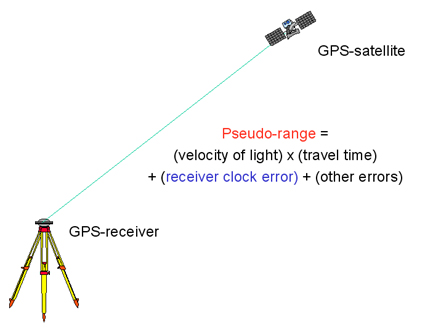

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [6]:
df_pseudorange = pd.read_excel("pseudoranges1.xlsx")
df_sat_pos = pd.read_excel('satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size


Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [7]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])
print(GroundTruth)

[-1633489.37967725 -3651627.18250363  4952481.61954918]


Step 0.4: Intialize empty arrays

In [8]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [9]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)
    return distance

distance = euclidean_norm(GroundTruth,sat_pos)
print(distance)

[22919735.50416796 20459891.58181501 22400334.25542599 22829138.20273155
 22342011.77899318 25646450.14718576 23814770.16593441 24311391.26510924
 21353638.3890343  24971604.82362354 20638980.11687546]


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [10]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    num_sats = len(pseudorange)
    cost = 0
    predicted_pseudoranges = np.array(euclidean_norm(r_pos,s_pos)) + cdT
    residuals = pseudorange - predicted_pseudoranges
    L = np.sum(residuals**2)/n
    return L
print(cost_function(GroundTruth,0,sat_pos,pseudorange))



19.828448408602423


### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [11]:
def gradient(r_pos, cdT, s_pos, pseudorange):
    num_sats = len(pseudorange)
    grad = np.zeros(4)  # Initialize gradient vector for x_r, y_r, z_r, cdT
    geometric_distance = euclidean_norm(r_pos,s_pos)
    predicted_pseudoranges = geometric_distance + cdT
    residuals = pseudorange - predicted_pseudoranges

    for i in range(num_sats):
        # Calculate geometric distance
        diff = r_pos - s_pos[i]
        distance = np.linalg.norm(diff)

        if distance != 0:
          grad[0] = grad[0] + 2 * residuals[i] * (-diff[0] / distance)
          grad[1] = grad[1] + 2 * residuals[i] * (-diff[1] / distance)
          grad[2] = grad[2] + 2 * residuals[i] * (-diff[2] / distance)

          grad[3] = -2 * np.sum(residuals)

    return grad  # Return the calculated gradient vector

grad = gradient(GroundTruth,0,sat_pos,pseudorange)
print(grad)

[ 12.33149924 -10.78111633  41.1025859  -87.79500721]


### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [12]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos,cdT,s_pos,pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos,cdT,s_pos,pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * grad

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3],X_new[3],s_pos,pseudorange)

         # If cost increases, reduce learning rate and retry
        if new_cost > current_cost:
            learning_rate *= 0.5  # Reduce learning rate by a factor of 0.5
            X_new = X - learning_rate * grad  # Update estimates with reduced learning rate
            new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)


        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [13]:
# Call gradient_descent to optimize the parameters
optimized_params = gradient_descent(pseudorange, sat_pos)

# Compute final position error and other metrics
final_gradient = gradient(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)
final_cost = cost_function(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)
final_position_error = optimized_params[:3] - GroundTruth

print("Optimized Parameters :", optimized_params)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Gradient Values:", final_gradient)
print("Final Cost Value:", final_cost)
print("Final Position Errors of Receiver:", final_position_error)



Converged !
Optimized Parameters : [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.44954762e+00]
Number of Steps Taken for Convergence: 2700
Final Gradient Values: [ 0.00161511  0.00899931 -0.02765869 -0.0156805 ]
Final Cost Value: 0.563436913173813
Final Position Errors of Receiver: [-3.06252556 -2.346982    3.77353113]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

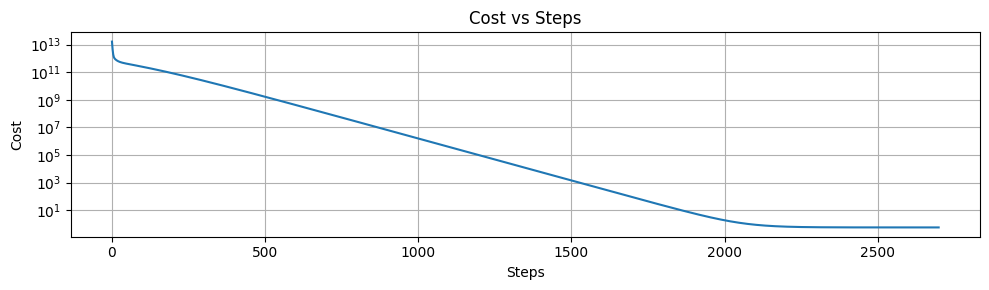

In [14]:
# Create plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,3))

# Plot cost vs steps using semilogy
ax.semilogy(arr_cost,)

# Label axes
ax.set_xlabel('Steps')
ax.set_ylabel('Cost')

# Add title
ax.set_title('Cost vs Steps')

# Add grid
ax.grid(True)

# Adjust layout
fig.tight_layout()

# Show plot
plt.show()
# Comment on the pattern
# The graph of Cost versus Steps below shows that, initially, the cost (representing the difference between observed and predicted receiver coordinates) was very high. There was a sharp decline in cost during the first iteration, followed by a gradual decrease as the iterations continued. This reduction in cost slowed progressively, becoming inversely proportional to the iteration steps, until around 2000 steps, where it started to level off. Beyond 2000 steps, additional optimization had minimal or no effect on reducing the cost, which had reached its lowest achievable value. This plateau indicates that the optimization process had converged after 2000+ iterations.

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

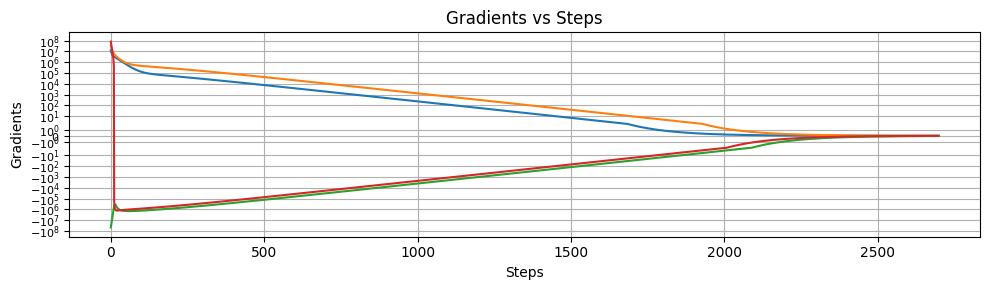

In [15]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
ax.plot(arr_grad)
ax.set_yscale('symlog')
ax.tick_params(axis='y', labelsize=8)
ax.set_xlabel('Steps')
ax.set_ylabel('Gradients')
ax.set_title('Gradients vs Steps')
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# The plot illustrates a successful gradient descent process, showing a sharp initial reduction in gradient, followed by slower, gradual convergence. This pattern reflects rapid adjustments early on, with finer tuning as it nears the optimal solution, and differing convergence rates among the variables.

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

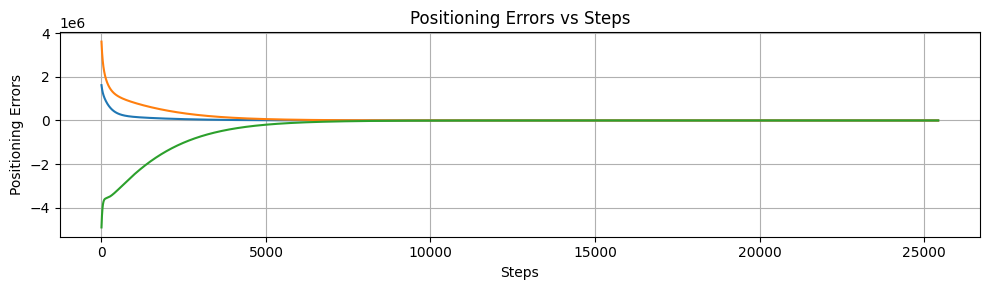

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(arr_err)
ax.set_xlabel('Steps')
ax.set_ylabel('Positioning Errors')
ax.set_title('Positioning Errors vs Steps')
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
#The plot illustrates efficient gradient descent optimization, showing a quick reduction in error across all coordinates at the beginning, followed by stabilization close to zero. A small residual error remains only in the z-coordinate. This trend confirms successful convergence of the optimization process.

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [17]:
#set learning rate to 0.01
learning_rate=0.01
max_iters=150000
tolerance=1e-6
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate, max_iters, tolerance)

# print the metrics
print(f"--- Learning Rate: {learning_rate} ---")
print(f"Optimized Parameters: {optimized_params_2}")
print(f"Final position errors of receiver: {arr_err[-1]}")
print(f"Number of steps taken for convergence: {steps_count}")
print(f"Final cost value: {arr_cost[-1]}")
print(f"Final gradient values: {arr_grad[-1]}")

Converged !
--- Learning Rate: 0.01 ---
Optimized Parameters: [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.44954762e+00]
Final position errors of receiver: [-3.06252556 -2.346982    3.77353113]
Number of steps taken for convergence: 2700
Final cost value: 0.5634379196310744
Final gradient values: [ 0.00162646  0.00906259 -0.0278531  -0.01579068]


In [18]:
#set learning rate to 0.001
learning_rate=0.001
max_iters=200000
tolerance=1e-6

#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

# Performing gradient descent with specified learning rate
optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate, max_iters, tolerance)

# print the metrics
print(f"--- Learning Rate: {learning_rate} ---")
print(f"Optimized Parameters: {optimized_params_3}")
print(f"Final position errors of receiver: {arr_err[-1]}")
print(f"Number of steps taken for convergence: {steps_count}")
print(f"Final cost value: {arr_cost[-1]}")
print(f"Final gradient values: {arr_grad[-1]}")


Converged !
--- Learning Rate: 0.001 ---
Optimized Parameters: [-1.63349244e+06 -3.65162950e+06  4.95248531e+06  6.40077571e+00]
Final position errors of receiver: [-3.05750202 -2.31899094  3.68750284]
Number of steps taken for convergence: 25431
Final cost value: 0.5640833056318891
Final gradient values: [ 0.0051249   0.02855582 -0.08776402 -0.04975592]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

Q1. From the results obtained after adjusting the learning rate from 0.1 to 0.01 and 0.001, it was observed that the gradient descent algorithm converged more quickly at a learning rate of 0.01, requiring only 2700 iterations to reach convergence. In contrast, when the learning rate was reduced to 0.01 and 0.001, convergence took 2700 and 25431 steps in both cases respectively. This demonstrates that a higher learning rate leads to faster convergence, while a lower learning rate results in smaller adjustments per step, thereby slowing down the convergence process. Additionally, the positional coordinate errors of the receiver were slightly lower with the two lower learning rates (0.01 and 0.001) compared to 0.1. This suggests that, although optimization may be slower at lower learning rates, it yields a marginally more precise outcome than the higher learning rate.

Q2. Both Least Square Estimation (LSE) and Gradient Descent are optimization techniques. LSE is primarily used for linear models, such as linear regression, and if the model is nonlinear, it must first be linearized before optimization begins. LSE works by minimizing the sum of squared residuals, which represents the difference between the predicted and actual values.
Gradient Descent, however, is a more versatile optimization method that minimizes the loss function by iteratively adjusting the model's parameters in the direction of the steepest decrease. It is applicable to both linear and nonlinear models, eliminating the need for linearization of complex models and avoiding truncation of parameters.

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [20]:
!pip install ucimlrepo

In [21]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
X = phishing_websites.data.features
y = phishing_websites.data.targets

# TO DO: display sizes of X and y (1 mark)
print (X.shape)
print (y.shape)

(11055, 30)
(11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

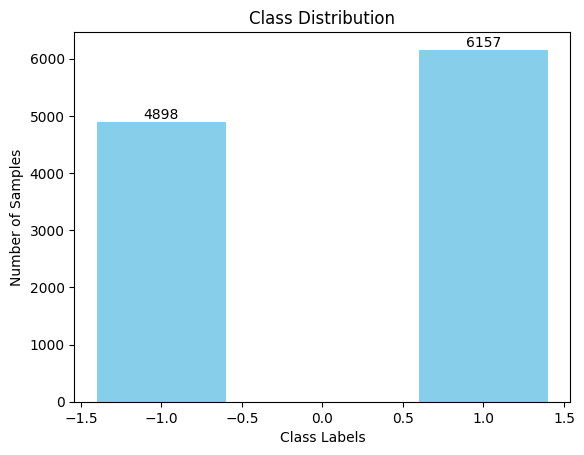

In [22]:
# TO DO: Check the class distribution of y (2 mark)
import matplotlib.pyplot as plt
import numpy as np

# y_small is your target vector with class labels
unique_classes, counts = np.unique(y, return_counts = True)


#Plotting the histogram
fig, ax = plt.subplots()
bars = ax.bar(unique_classes, counts, color='skyblue')
ax.set_xlabel("Class Labels")
ax.set_ylabel("Number of Samples")
ax.set_title("Class Distribution")

#Annotate each bar with the count value
ax.bar_label(bars, label_type='edge')

# Display exact values for each bin in the histogram
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [23]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split

# Assuming X and y are your original feature matrix and target vector
X_small, _, y_small, _ = train_test_split(X, y, train_size=0.03, random_state=42)




# TO DO: display sizes of X_small and y_small (2 mark)
print("New feature matrix X_small shape:", X_small.shape)
print("New target vector y_small shape:", y_small.shape)


New feature matrix X_small shape: (331, 30)
New target vector y_small shape: (331, 1)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [24]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information

# Initialize a list to store the results
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split

#initialize logistic Regression Model
def train_logistic_regression(X, y):
    y = y.values.ravel()
    # Splitting the data (70% train, 30% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train)

    return model, X_train, X_test, y_train, y_test

# Implementing model on full dataset
model_full, X_train_full, X_test_full, y_train_full, y_test_full = train_logistic_regression(X, y)

# first two columns of x
X_first_two = X.iloc[:, :2]

# Implementing model on dataset with first two columns
model_two_cols, X_train_two_cols, X_test_two_cols, y_train_two_cols, y_test_two_cols = train_logistic_regression(X_first_two, y)

# Implementing model on smaller dataset
model_small, X_train_small, X_test_small, y_train_small, y_test_small = train_logistic_regression(X_small, y_small)

#Step 4:
# Define the evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test):

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)

    #data size
    data_size = len(X_train) + len(X_test)

    #training samples
    train_samples = len(X_train)

    #testing samples
    test_samples = len(X_test)

    #training accuracy
    train_accuracy = accuracy_score(y_train, y_train_pred)

    #testing accuracy
    test_accuracy = accuracy_score(y_test, y_test_pred)

    #log loss
    loss = log_loss(y_test, y_test_proba)

    # Returning results as a dictionary
    return {
        "Data size": data_size,
        "Training samples": train_samples,
        "Testing samples": test_samples,
        "Training accuracy": train_accuracy,
        "Testing accuracy": test_accuracy,
        "Log loss": loss
    }

# Full dataset
metrics_full = evaluate_model(model_full, X_train_full, X_test_full, y_train_full, y_test_full)

# First two columns
metrics_two_cols = evaluate_model(model_two_cols, X_train_two_cols, X_test_two_cols, y_train_two_cols, y_test_two_cols)

# Smaller dataset
metrics_small = evaluate_model(model_small, X_train_small, X_test_small, y_train_small, y_test_small)

# Step 5.1: Visualize Results
# Create DataFrames for each dataset's results with the specified columns
df_full = pd.DataFrame([metrics_full], columns=[
    "Data size",
    "Training samples",
    "Testing samples",
    "Training accuracy",
    "Testing accuracy",
    "Log loss"
])

df_two_cols = pd.DataFrame([metrics_two_cols], columns=[
    "Data size",
    "Training samples",
    "Testing samples",
    "Training accuracy",
    "Testing accuracy",
    "Log loss"
])

df_small = pd.DataFrame([metrics_small], columns=[
    "Data size",
    "Training samples",
    "Testing samples",
    "Training accuracy",
    "Testing accuracy",
    "Log loss"
])

# Concatenate the DataFrames with custom row names
results = pd.concat([df_full, df_two_cols, df_small], ignore_index=True)

# Set custom row names (index)
results.index = ["Full Dataset", "First Two Columns", "Smaller Dataset"]

# Print the results DataFrame
print("Results Summary:")
print(results)





Results Summary:
                   Data size  Training samples  Testing samples  \
Full Dataset           11055              7738             3317   
First Two Columns      11055              7738             3317   
Smaller Dataset          331               231              100   

                   Training accuracy  Testing accuracy  Log loss  
Full Dataset                0.932282          0.922822  0.190326  
First Two Columns           0.562807          0.556828  0.683573  
Smaller Dataset             0.943723          0.910000  0.200366  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [25]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set

y_test_full = y_test_full #Actual
y_test_predicted = model_full.predict (X_test_full)#Predicted

print("Dimension of predicted output:", y_test_predicted.shape)


Dimension of predicted output: (3317,)


Text(113.9222222222222, 0.5, 'true value')

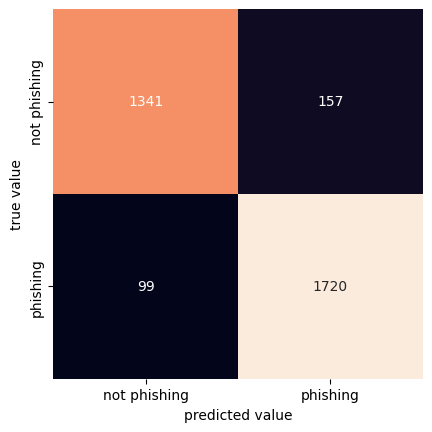

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
conf_mat = confusion_matrix(y_test_full, y_test_predicted)

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [31]:
# TO DO: Print classification report (2 marks)
from sklearn.metrics import classification_report #Import the classification_report function
print(classification_report(y_test_full, y_test_predicted, target_names=['not phishing', 'phishing']))

              precision    recall  f1-score   support

not phishing       0.93      0.90      0.91      1498
    phishing       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

1. The dataset shows a slight imbalance, as indicated by the "support" column. While there is a noticeable difference between the support values for class -1 (1498) and class 1 (1819), this does not significantly affect the results since both classes are nearly equal in proportion. The classification report reveals similar precision, recall, and F1-scores for both classes (around 0.92 to 0.93), indicating that the model performs well across them. Therefore, the slight imbalance in the dataset has a minimal impact on the model's performance.

2. **Case 1 - Using the full X and Y dataset:** The training and testing accuracies were 0.957 and 0.940, respectively. This small decrease in test accuracy indicates good generalization, suggesting that the model is well-suited to this dataset.

 **Case 2 - Using only the first two columns of the X and Y dataset:** The training and testing accuracies were 0.519 and 0.510, respectively, indicating a very low level of accuracy and suggesting "underfitting." This occurs because the model lacks sufficient information to capture the dataset's complexity.

 **Case 3 - Using the X_small and Y_small dataset:** In this case, the training and testing accuracies were 1 and 0.667, respectively. This reflects very high accuracy on the training data but significantly lower accuracy on the test data, indicating "overfitting." With the smaller dataset, the model memorizes limited patterns in the training data, resulting in poor generalization to new data.

3. **Case 1 - Using the full X and Y dataset:** With the complete dataset and all features, the model has ample information to learn data patterns. The training accuracy was high at 95.7%, indicating a good fit to the training data, while the testing accuracy was also high at 94.0%, suggesting effective generalization to new data. This close match between training and testing accuracy shows that the model is well-suited to the dataset.

 **Case 2 - Using only the first two columns of X and Y dataset:** Limiting the input to just the first two columns reduced the model's information, resulting in poor training and testing accuracies of 51.9% and 51.0%, respectively. This indicates underfitting, as the model lacks the capacity to capture the data's complexity with limited input, leading to low accuracy on both the training and testing sets.

 **Case 3 - Using X_small and Y_small dataset:** With only 3% of the dataset, the model achieved a perfect training accuracy (100%), but testing accuracy dropped sharply to 66.7%. This accuracy pattern points to overfitting, as the model memorized the small training set’s specific details rather than learning general patterns. Using such a limited dataset often leads to overfitting, as the model cannot generalize effectively to broader data.

4. **False Positive:** When a harmless email is mistakenly flagged as phishing, it can cause considerable inconvenience, delays in response, or even blocked legitimate communication. Users may have to spend time retrieving and verifying such emails, which can significantly disrupt workflow.

 **False Negative:** In this scenario, a phishing email is mistakenly classified as safe. This is particularly dangerous as it allows attackers access to the user’s system, exposing them to various security threats.In this context, a False Negative is more severe, as malicious emails can slip through undetected, and by the time they’re discovered, significant damage may already have occurred.

5. In this scenario, prioritizing high recall is essential because it ensures the model correctly identifies most phishing emails, reducing the chance of dangerous phishing emails being mistakenly classified as safe.

6. **Case 1 - Using the full X and Y dataset:** The log loss is very low at 0.190326, suggesting that the model is both confident and accurate in predicting class probabilities with the full dataset. This low log loss indicates that the model can effectively differentiate between classes due to the presence of all features, allowing it to make well-calibrated probability predictions.

 **Case 2 - Using only the first two columns of X and Y dataset:** The log loss is much higher at 0.683573, indicating that the model is less confident and accurate in its predictions. With only the first two columns, the model lacks sufficient information to capture the data's complexity, leading to poorly calibrated probability estimates.

 **Case 3 - Using the X_small and Y_small dataset:** The log loss here is 0.243140, which is lower than in Case 2 but higher than in Case 1. This suggests that, although the model overfits the small training subset, it still has enough features to learn some patterns. However, due to the limited data size, it struggles to generalize these patterns to new data, resulting in poorly calibrated probabilities on the test set and a moderate log loss. The high accuracy on the training data may not reflect true performance on unseen data, contributing to this elevated log loss.